# Airline Review Sentiment Analysis Project 

In [329]:
# Import all required libraries

import nltk
import numpy as np
import re
import pandas as pd 
import pylab as pl
import matplotlib.pyplot as plt


from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

import datashader as ds
import datashader.transfer_functions as tf

1. Data Loading and Exploration:
You started by importing essential libraries and reading the dataset from the provided CSV file. The dataset contains airline reviews, and the initial exploration includes checking unique airlines, flights on the same date, and unique routes.

In [330]:
# Read the dataset

df = pd.read_csv("D:\Projects\ML\Bounty\Airline_review.csv",encoding='UTF-8')
print(len(df))

23171


In [331]:
df.head(2)

Serial_No Airline_Name Overall_Rating             Review_Title  \
0          0  AB Aviation              9  "pretty decent airline"   
1          1  AB Aviation              1     "Not a good airline"   

          Review_Date  Verified  \
0  11th November 2019      True   
1      25th June 2019      True   

                                              Review Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...      NaN   
1   Moroni to Anjouan. It is a very small airline...     E120   

  Type_of_Travellerclass_type      Seat Type              Route Date_Flown  
0                Solo Leisure  Economy Class   Moroni to Moheli     Nov-19  
1                Solo Leisure  Economy Class  Moroni to Anjouan     Jun-19

In [332]:
# Number of unique Airlines
unique_airlines = df.Airline_Name.unique()
len(unique_airlines)

497

In [333]:
# Number of Airlines with flown on same date

df["Date_Flown"].value_counts(ascending=False).head(2)

Date_Flown
Jun-23    1057
Jul-23     814
Name: count, dtype: int64

In [334]:
# Unique routes
unique_route = df.Route.unique()
print(len(unique_route))
df.Route.value_counts().head(10)

13608


Route
Melbourne to Sydney          43
Sydney to Melbourne          35
Cape Town to Johannesburg    34
Cusco to Lima                30
Bangkok to Phuket            28
Kuala Lumpur to Singapore    27
Johannesburg to Cape Town    27
Bangkok to Chiang Mai        26
Johannesburg to Durban       22
Toronto to Calgary           21
Name: count, dtype: int64

In [335]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [336]:
df['Clean_text'] = np.vectorize(remove_pattern)(df['Review'], "@[\w]*")

In [337]:
# remove special characters, numbers, punctuations
df['Clean_text'] = df['Clean_text'].str.replace("[^a-zA-Z#]", " ")

In [338]:
df['Clean_text'] = df['Clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [339]:
tokenized_review = df['Clean_text'].apply(lambda x: x.split())

In [340]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_review.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_review.head()

0    [Moroni, Moheli., Turned, pretty, decent, airl...
1    [Moroni, Anjouan., very, small, airline., tick...
2    [Anjouan, Dzaoudzi., very, small, airline, onl...
3    [Please, favor, yourself, with, Adria., route,...
4    [book, flight, with, this, airline!, friend, s...
Name: Clean_text, dtype: object

In [341]:
for i in range(len(tokenized_review)):
    tokenized_review[i] = ' '.join(tokenized_review[i])

df['Clean_text'] = tokenized_review

In [342]:
df.loc[:,('Review','Clean_text')]

Review  \
0        Moroni to Moheli. Turned out to be a pretty ...   
1       Moroni to Anjouan. It is a very small airline...   
2        Anjouan to Dzaoudzi. A very small airline an...   
3        Please do a favor yourself and do not fly wi...   
4       Do not book a flight with this airline! My fr...   
...                                                  ...   
23166   Bangkok to Tokyo. I’ve flown many low cost ai...   
23167    Avoid at all costs. I booked flights to go f...   
23168    Flight was leaving at 23.15 and after an hou...   
23169   Zipair is JAL’s budget airline. They don’t ha...   
23170    They lied about connection in Narita and we ...   

                                              Clean_text  
0      Moroni Moheli. Turned pretty decent airline. O...  
1      Moroni Anjouan. very small airline. ticket adv...  
2      Anjouan Dzaoudzi. very small airline only airl...  
3      Please favor yourself with Adria. route from M...  
4      book flight with this airline! friend should h...  
...                                                  ...  
23166  Bangkok Tokyo. I’ve flown many cost airlines b...  
23167  Avoid costs. booked flights from Singapore Tok...  
23168  Flight leaving 23.15 after hour half flying ba...  
23169  Zipair JAL’s budget airline. They don’t have c...  
23170  They lied about connection Narita lost money w...  

[23171 rows x 2 columns]

In [343]:
# Checking for null review
df[df.Review.isnull()]
df[df.Clean_text.isnull()]

Empty DataFrame
Columns: [Serial_No, Airline_Name, Overall_Rating, Review_Title, Review_Date, Verified, Review, Aircraft, Type_of_Travellerclass_type, Seat Type, Route, Date_Flown, Clean_text]
Index: []

In [344]:
# Number of unique reviews
unique_clean_text = df.Clean_text.unique()
unique_review = df.Review.unique()
print(len(unique_clean_text))
print(len(unique_review))
print(len(df))

23046
23046
23171


In [345]:
df.drop_duplicates(subset=['Clean_text'], keep = 'first',inplace= True)
df.reset_index(drop=True,inplace=True)
df['Clean_text_length'] = df['Clean_text'].apply(len)
df.head(2)

Serial_No Airline_Name Overall_Rating             Review_Title  \
0          0  AB Aviation              9  "pretty decent airline"   
1          1  AB Aviation              1     "Not a good airline"   

          Review_Date  Verified  \
0  11th November 2019      True   
1      25th June 2019      True   

                                              Review Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...      NaN   
1   Moroni to Anjouan. It is a very small airline...     E120   

  Type_of_Travellerclass_type      Seat Type              Route Date_Flown  \
0                Solo Leisure  Economy Class   Moroni to Moheli     Nov-19   
1                Solo Leisure  Economy Class  Moroni to Anjouan     Jun-19   

                                          Clean_text  Clean_text_length  
0  Moroni Moheli. Turned pretty decent airline. O...                268  
1  Moroni Anjouan. very small airline. ticket adv...                467

In [346]:
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23046 entries, 0 to 23045
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Serial_No                    23046 non-null  int64 
 1   Airline_Name                 23046 non-null  object
 2   Overall_Rating               23046 non-null  object
 3   Review_Title                 23046 non-null  object
 4   Review_Date                  23046 non-null  object
 5   Verified                     23046 non-null  bool  
 6   Review                       23046 non-null  object
 7   Aircraft                     7125 non-null   object
 8   Type_of_Travellerclass_type  19421 non-null  object
 9   Seat Type                    22058 non-null  object
 10  Route                        19332 non-null  object
 11  Date_Flown                   19406 non-null  object
 12  Clean_text                   23046 non-null  object
 13  Clean_text_length            23

In [347]:
from textblob import TextBlob
TextBlob('Friendly flight attendant who take care of the passengers efficiently. Excellent flight, but the cabin of the Dash 8-100 needs a very serious refresh and more confortable seats. The flight time was respected. On the gate, the employees of Air Canada Jazz offer a good service.').sentiment

Sentiment(polarity=0.3902777777777778, subjectivity=0.6444444444444445)

In [348]:
TextBlob("Mumbai to Amsterdam. Worst airline ever. I flight to Delhi on April 6th, plane was dirty, old, food basic. No entertaiment on board. What is more on the way back the flight was cancelled and I needed to wait in Mumbai for two days. Now it is not possible to get any refund from the airline as the ticket was bought via company in Europe. If they ever start to operate again do not buy tickets from that airline.").sentiment

Sentiment(polarity=-0.14285714285714285, subjectivity=0.5178571428571429)

In [349]:
def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [350]:
df['sentiment']=df.Clean_text.apply(calculate_sentiment)
df['sentiment_analyser']=df.Clean_text.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(df)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(df)): 
  s['compound_score'][i] = df['sentiment_analyser'][i]['compound']
  
  if (df['sentiment_analyser'][i]['compound'] <= -0.05):
    s['compound_score_sentiment'][i] = 'Negative'    
  if (df['sentiment_analyser'][i]['compound'] >= 0.05):
    s['compound_score_sentiment'][i] = 'Positive'
  if ((df['sentiment_analyser'][i]['compound'] >= -0.05) & (df['sentiment_analyser'][i]['compound'] <= 0.05)):
    s['compound_score_sentiment'][i] = 'Neutral'
    
df['compound_score'] = s['compound_score']
df['compound_score_sentiment'] = s['compound_score_sentiment']
df.head(4)


Serial_No   Airline_Name Overall_Rating  \
0          0    AB Aviation              9   
1          1    AB Aviation              1   
2          2    AB Aviation              1   
3          3  Adria Airways              1   

                          Review_Title          Review_Date  Verified  \
0              "pretty decent airline"   11th November 2019      True   
1                 "Not a good airline"       25th June 2019      True   
2       "flight was fortunately short"       25th June 2019      True   
3  "I will never fly again with Adria"  28th September 2019     False   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an...  Embraer E120    
3    Please do a favor yourself and do not fly wi...            NaN   

  Type_of_Travellerclass_type      Seat Type                  Route  \
0                Solo Leisure  Economy Class       Moroni to Moheli   
1                Solo Leisure  Economy Class      Moroni to Anjouan   
2                Solo Leisure  Economy Class    Anjouan to Dzaoudzi   
3                Solo Leisure  Economy Class  Frankfurt to Pristina   

  Date_Flown                                         Clean_text  \
0     Nov-19  Moroni Moheli. Turned pretty decent airline. O...   
1     Jun-19  Moroni Anjouan. very small airline. ticket adv...   
2     Jun-19  Anjouan Dzaoudzi. very small airline only airl...   
3     Sep-19  Please favor yourself with Adria. route from M...   

   Clean_text_length                                    sentiment  \
0                268     (0.3022222222222222, 0.6261111111111112)   
1                467   (0.010416666666666666, 0.4183333333333333)   
2                313                 (0.08499999999999999, 0.624)   
3                594  (-0.025000000000000005, 0.4763888888888889)   

                                  sentiment_analyser compound_score  \
0  {'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...         0.9259   
1  {'neg': 0.091, 'neu': 0.819, 'pos': 0.09, 'com...        -0.0258   
2  {'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...         0.8264   
3  {'neg': 0.243, 'neu': 0.706, 'pos': 0.05, 'com...        -0.9523   

  compound_score_sentiment  
0                 Positive  
1                  Neutral  
2                 Positive  
3                 Negative

In [351]:
#Dropping un neccessary columns
df.drop(['Overall_Rating','Review_Title','Review_Date','Verified','Review','Aircraft','Type_of_Travellerclass_type','Seat Type','Route'],axis=1)

Serial_No   Airline_Name Date_Flown  \
0              0    AB Aviation     Nov-19   
1              1    AB Aviation     Jun-19   
2              2    AB Aviation     Jun-19   
3              3  Adria Airways     Sep-19   
4              4  Adria Airways     Sep-19   
...          ...            ...        ...   
23041      23166         ZIPAIR     Jun-22   
23042      23167         ZIPAIR     Jun-22   
23043      23168         ZIPAIR     May-22   
23044      23169         ZIPAIR     May-22   
23045      23170         ZIPAIR     May-22   

                                              Clean_text  Clean_text_length  \
0      Moroni Moheli. Turned pretty decent airline. O...                268   
1      Moroni Anjouan. very small airline. ticket adv...                467   
2      Anjouan Dzaoudzi. very small airline only airl...                313   
3      Please favor yourself with Adria. route from M...                594   
4      book flight with this airline! friend should h...                400   
...                                                  ...                ...   
23041  Bangkok Tokyo. I’ve flown many cost airlines b...                628   
23042  Avoid costs. booked flights from Singapore Tok...                598   
23043  Flight leaving 23.15 after hour half flying ba...                669   
23044  Zipair JAL’s budget airline. They don’t have c...               2271   
23045  They lied about connection Narita lost money w...                223   

                                          sentiment  \
0          (0.3022222222222222, 0.6261111111111112)   
1        (0.010416666666666666, 0.4183333333333333)   
2                      (0.08499999999999999, 0.624)   
3       (-0.025000000000000005, 0.4763888888888889)   
4                       (0.175, 0.5229166666666667)   
...                                             ...   
23041  (-0.017222222222222215, 0.39055555555555554)   
23042    (0.08333333333333334, 0.49444444444444446)   
23043    (0.04004329004329005, 0.16028138528138527)   
23044     (0.1629761904761905, 0.46118452380952385)   
23045                                    (0.0, 0.5)   

                                      sentiment_analyser compound_score  \
0      {'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...         0.9259   
1      {'neg': 0.091, 'neu': 0.819, 'pos': 0.09, 'com...        -0.0258   
2      {'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...         0.8264   
3      {'neg': 0.243, 'neu': 0.706, 'pos': 0.05, 'com...        -0.9523   
4      {'neg': 0.107, 'neu': 0.722, 'pos': 0.171, 'co...         0.5093   
...                                                  ...            ...   
23041  {'neg': 0.144, 'neu': 0.842, 'pos': 0.014, 'co...         -0.911   
23042  {'neg': 0.087, 'neu': 0.81, 'pos': 0.103, 'com...         0.1298   
23043  {'neg': 0.046, 'neu': 0.929, 'pos': 0.025, 'co...        -0.2732   
23044  {'neg': 0.031, 'neu': 0.829, 'pos': 0.14, 'com...         0.9904   
23045  {'neg': 0.251, 'neu': 0.697, 'pos': 0.052, 'co...        -0.7906   

      compound_score_sentiment  
0                     Positive  
1                      Neutral  
2                     Positive  
3                     Negative  
4                     Positive  
...                        ...  
23041                 Negative  
23042                 Positive  
23043                 Negative  
23044                 Positive  
23045                 Negative  

[23046 rows x 9 columns]

In [352]:
df.to_csv('D:/Projects/ML/Bounty/unique_clean_reviews_sentiment.csv')

In [353]:
df.compound_score_sentiment.value_counts()

compound_score_sentiment
Positive    12592
Negative     9973
Neutral       481
Name: count, dtype: int64

In [354]:
df['Clean_text'].head()

0    Moroni Moheli. Turned pretty decent airline. O...
1    Moroni Anjouan. very small airline. ticket adv...
2    Anjouan Dzaoudzi. very small airline only airl...
3    Please favor yourself with Adria. route from M...
4    book flight with this airline! friend should h...
Name: Clean_text, dtype: object

In [355]:
#tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Considering 3 grams and mimnimum frq as 0
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df['Clean_text'])
desc_matrix = tf_idf_vect.transform(df["Clean_text"])

In [356]:
# implement kmeans
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

c:\Users\tharu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [357]:
# create DataFrame films from all of the input files.
reviews = {'Review': df["Clean_text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(reviews)
frame

Review  Cluster
0      Moroni Moheli. Turned pretty decent airline. O...        0
1      Moroni Anjouan. very small airline. ticket adv...        2
2      Anjouan Dzaoudzi. very small airline only airl...        2
3      Please favor yourself with Adria. route from M...        0
4      book flight with this airline! friend should h...        2
...                                                  ...      ...
23041  Bangkok Tokyo. I’ve flown many cost airlines b...        2
23042  Avoid costs. booked flights from Singapore Tok...        0
23043  Flight leaving 23.15 after hour half flying ba...        2
23044  Zipair JAL’s budget airline. They don’t have c...        2
23045  They lied about connection Narita lost money w...        0

[23046 rows x 2 columns]

In [358]:
frame['Cluster'].value_counts()

Cluster
0    14920
2     6633
1     1493
Name: count, dtype: int64

In [359]:
frame[frame['Cluster'] == 1]

Review  Cluster
14     very unpleasant experience family. bought retu...        1
95     flight husband from Stockholm Cairo with conne...        1
100    took flights with Aegean would recommend them ...        1
116    flight returning Athens March cancelled. were ...        1
171    booked ComfortFlex ticket midday flight from A...        1
...                                                  ...      ...
22923  This worst flight have ever experienced, that ...        1
22938  booked flight Catania Paris stop months ago. b...        1
22978  return tickets London Bangladesh were cheap ch...        1
22982  London Aden (direct flight). Everything except...        1
23033  bought flight from Zipair July. will flight Au...        1

[1493 rows x 2 columns]

In [360]:
frame[frame['Cluster'] == 2]

Review  Cluster
1      Moroni Anjouan. very small airline. ticket adv...        2
2      Anjouan Dzaoudzi. very small airline only airl...        2
4      book flight with this airline! friend should h...        2
5      very experience with rerouted cancelled flight...        2
12     were traveling from Paris Skopje 4th, Ljubljan...        2
...                                                  ...      ...
23037  This worst service have ever received from air...        2
23039  issues started before even flew. recovered fro...        2
23041  Bangkok Tokyo. I’ve flown many cost airlines b...        2
23043  Flight leaving 23.15 after hour half flying ba...        2
23044  Zipair JAL’s budget airline. They don’t have c...        2

[6633 rows x 2 columns]

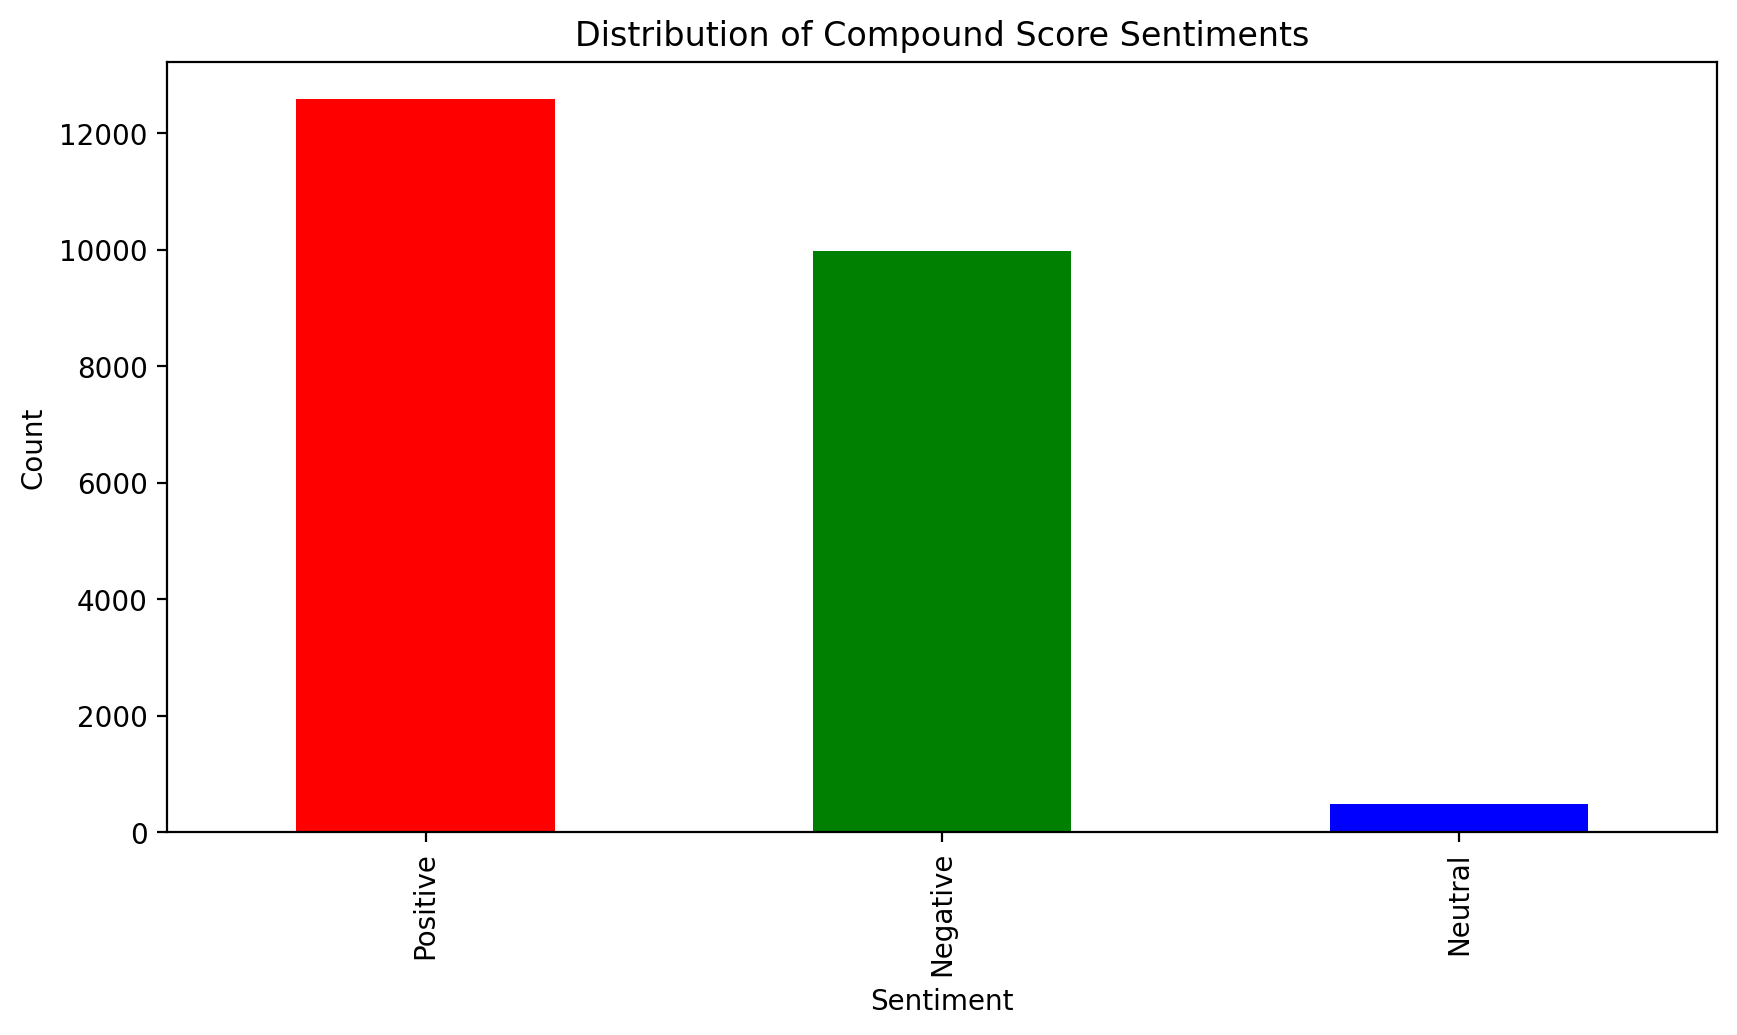

In [361]:
#Bar Plot
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['compound_score_sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(10,5))
sentiment_counts.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Distribution of Compound Score Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Airline_Name' is the column representing airline companies
plt.figure(figsize=(120,30))
custom_palette = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'yellow'}
sns.countplot(x='Airline_Name', hue='compound_score_sentiment', data=df, palette=custom_palette).legend(bbox_to_anchor=(5, 5))
plt.title('Sentiment Distribution Across Airline Companies')
plt.xlabel('Airline Company')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Sentiment')
plt.show()
#Manually zoom in to the analysis of each airline company

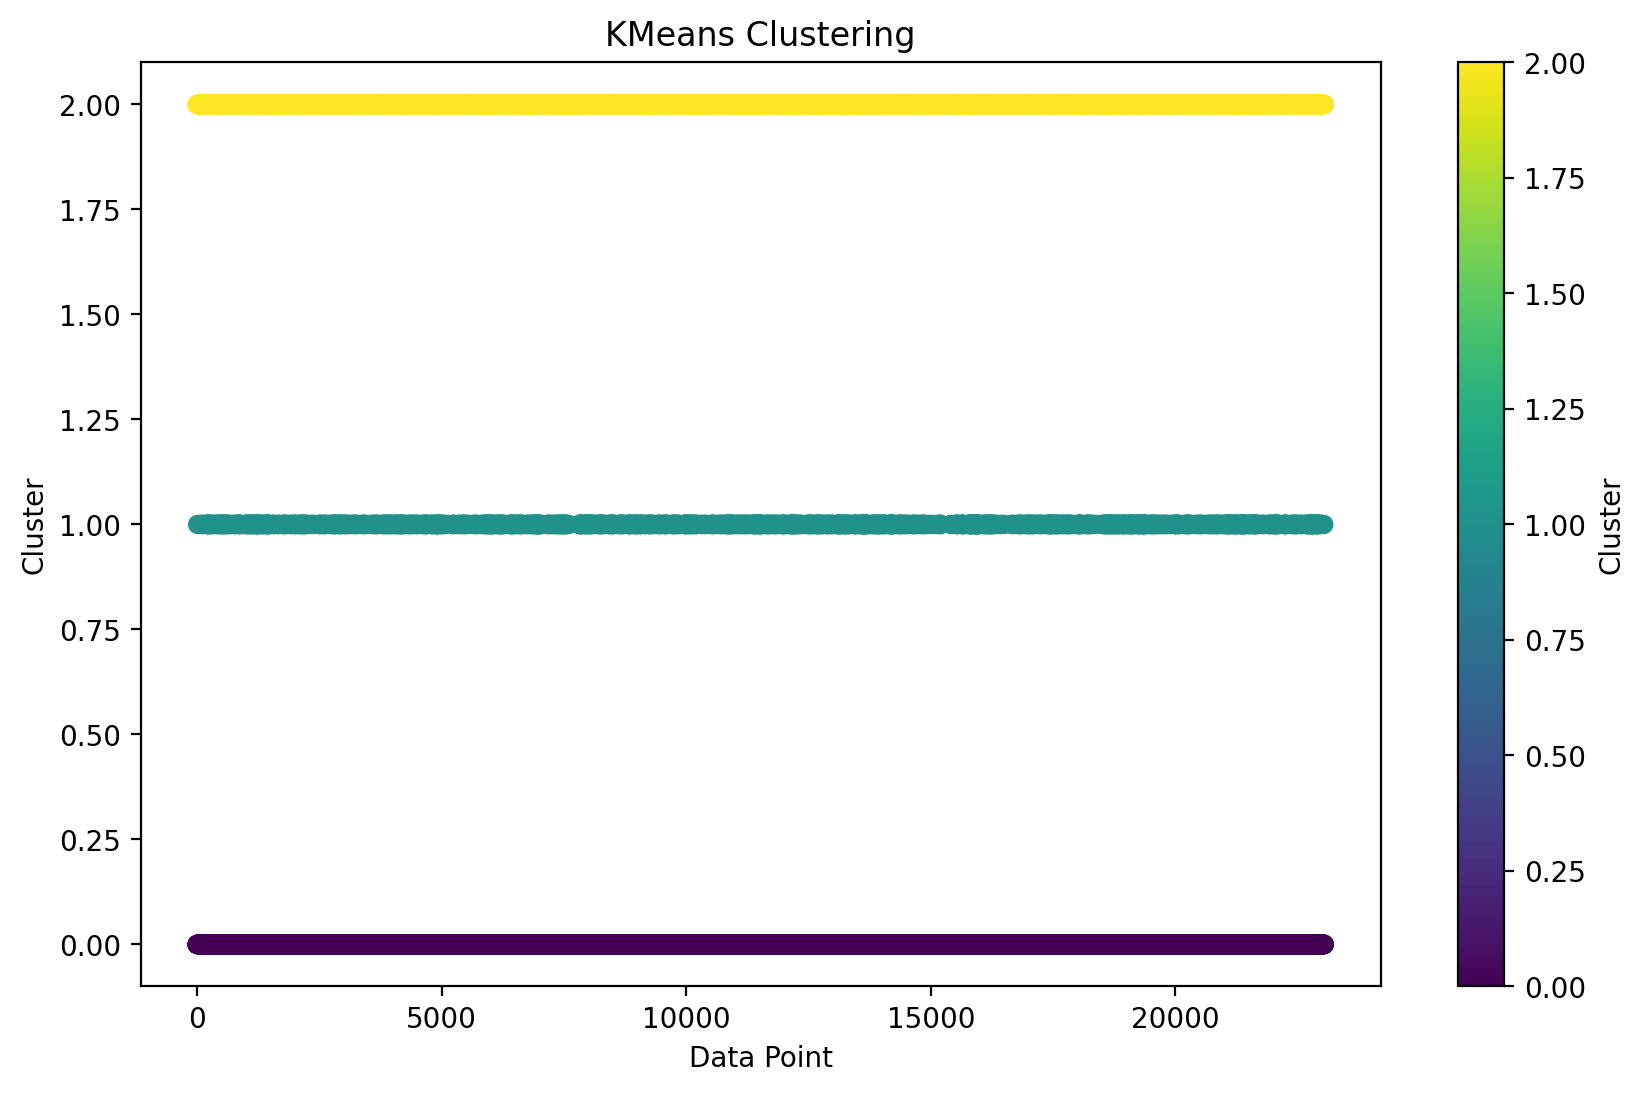

In [363]:
import matplotlib.pyplot as plt

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(frame)), frame['Cluster'], c=frame['Cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering')
plt.xlabel('Data Point')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster')
plt.show()


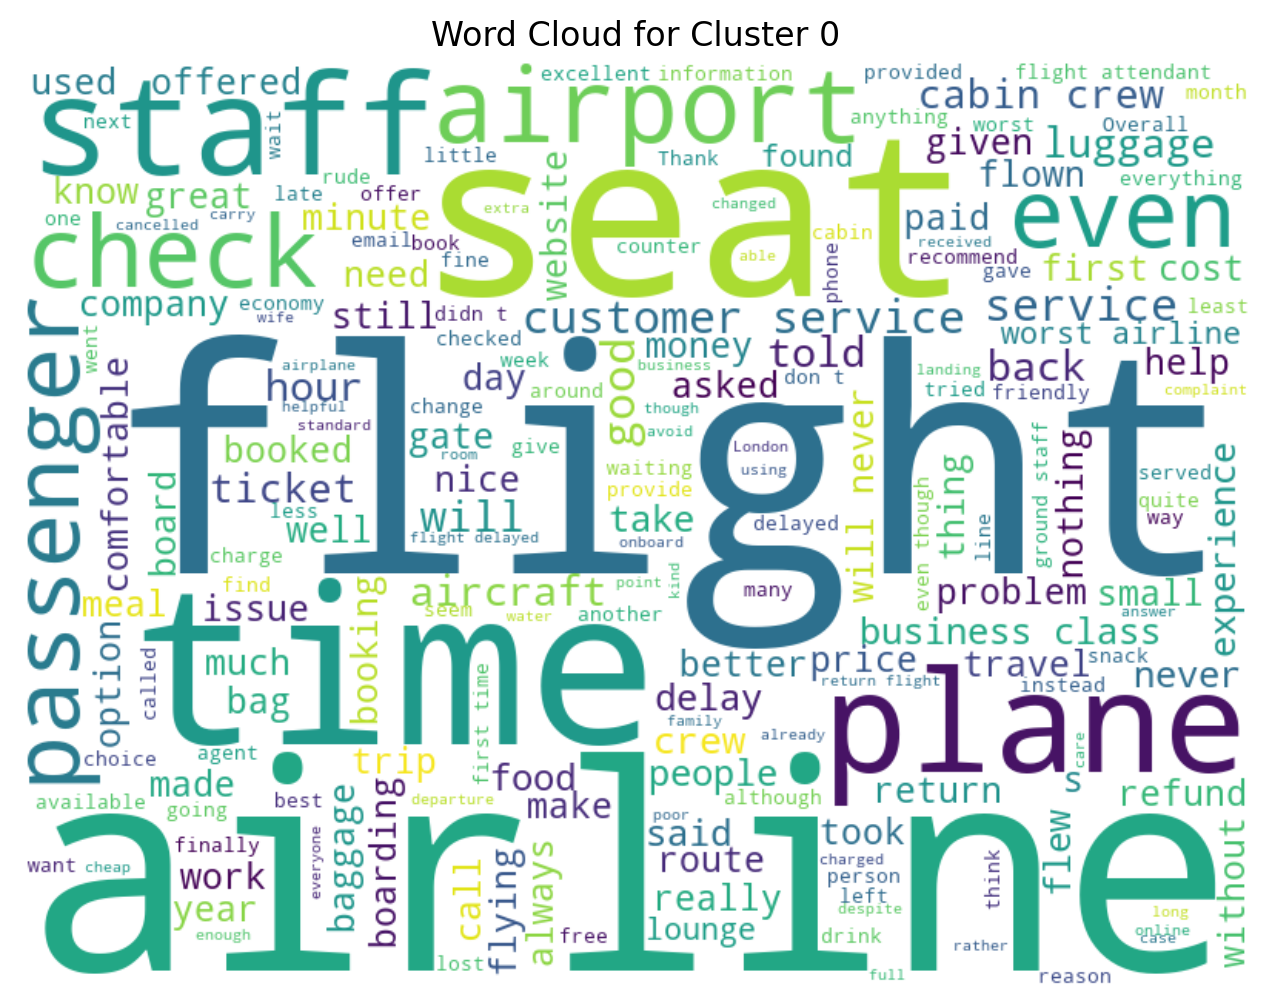

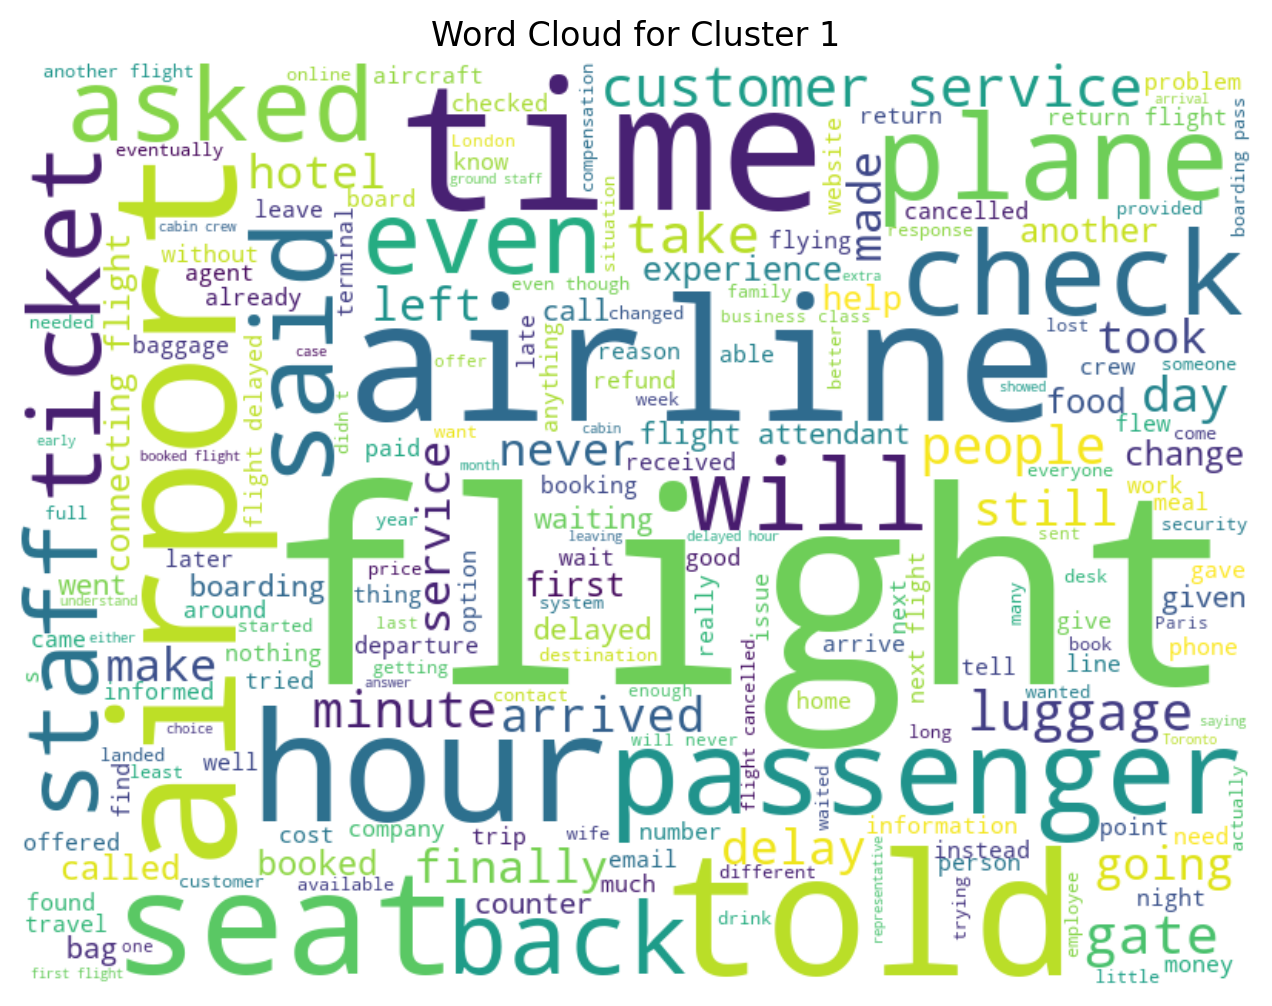

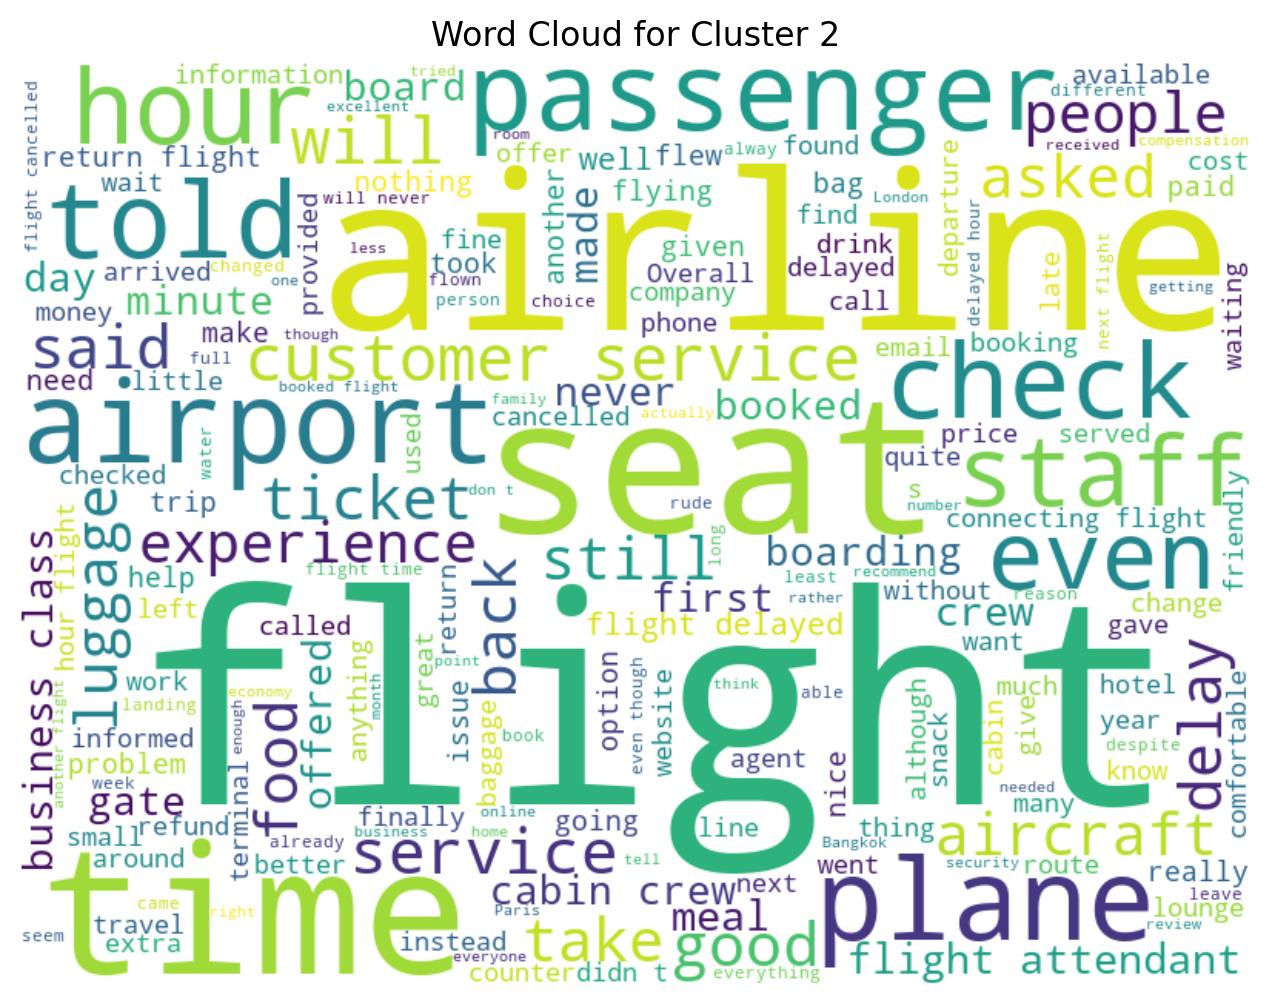

In [364]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud for each cluster
for cluster_num in range(num_clusters):
    cluster_text = ' '.join(frame[frame['Cluster'] == cluster_num]['Review'])
    
    plt.figure(figsize=(8, 6))
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(cluster_text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.axis('off')
    plt.show()


## Project Writeup

### Introduction

In this project, I performed sentiment analysis on airline reviews using natural language processing techniques. The dataset was loaded from a CSV file and underwent preprocessing for further analysis. I explored unique airlines, flights on the same date, and unique routes to understand the dataset's structure.

### Data Loading and Exploration

1. **Data Loading:**
   - Imported necessary libraries.
   - Read the dataset from a CSV file.

2. **Data Exploration:**
   - Checked the number of unique airlines.
   - Explored flights on the same date.
   - Identified unique flight routes.

### Text Cleaning and Preprocessing

1. **Text Cleaning:**
   - Defined a function to remove specific patterns from reviews.
   - Applied the function to remove patterns like mentions or hashtags.

2. **Text Preprocessing:**
   - Removed special characters, numbers, and punctuations.
   - Applied tokenization and stemming to clean text data.

### Sentiment Analysis

1. **TextBlob Sentiment Analysis:**
   - Utilized TextBlob to analyze sentiment in a sample review.
   - Showcased TextBlob's sentiment analysis on a negative review.

2. **VADER Sentiment Analysis:**
   - Implemented functions for sentiment analysis using the VADER Sentiment Analyzer.
   - Applied sentiment analysis to each cleaned review.

### Clustering Analysis

1. **TF-IDF Vectorization:**
   - Used TF-IDF vectorization to convert text data into numerical features.

2. **K-means Clustering:**
   - Applied k-means clustering based on TF-IDF features.
   - Explored grouping similar reviews using the cluster analysis.

### Results and Data Export

1. **Data Export:**
   - Exported the final DataFrame with sentiment information to a CSV file.

2. **Data Exploration and Visualization:**
   - Explored sentiment distribution.
   - Plotted Distribution of Compund Score Sentiments.
   - Plotted Sentiment Distribution Across Airline Companies.
   - Word Clouds for all three Clusters types - Positive, Negetive, neutral

### Conclusion and Future Enhancements

Concluded the project by summarizing insights gained and suggesting potential enhancements, such as model evaluation, additional feature engineering, and improved visualization techniques.Future enhancements could include model evaluation, feature engineering, and more sophisticated visualization techniques for a deeper understanding of customer sentiments. Overall, the project provided valuable insights into the sentiments expressed in airline reviews, paving the way for informed decision-making and enhanced customer satisfaction.